# Dataset Information:
**Dataset Summary:**
- **Source**: RT-IoT2022 from UCI ML Repository
- **Rows**: ~1,000,000+ (for full dataset)
- **Columns**: 85 total
  - **Features**: Network flow statistics like `flow_duration`, `fwd_pkts_tot`, `idle.min`, etc.
  - **Target**: `Attack_type` (12 unique network attack labels)
- **Data Types**: Mostly numerical, except for protocol-related features
- **Objective**: Multiclass classification to identify the type of IoT network attack


In [ ]:
# ✅ Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# ✅ Model selection and training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# ✅ Evaluation metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# ✅ Miscellaneous
import re
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output
from google.colab import drive



# Importing the dataset

In the cells below we will be importing the code from GoogleDrive. After importing the dataset we will test to see if the data was loaded correctly by displaying some data as well as the categories.

In [ ]:
# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Path to your dataset (adjust if needed)
data_path = '/content/drive/MyDrive/rt-iot2022/RT_IOT2022.csv'

# ✅ Load the dataset with error handling
try:
    df = pd.read_csv(data_path)
    print("✅ Dataset successfully loaded!")
except FileNotFoundError:
    print("❌ File not found. Please check the file path.")
except pd.errors.ParserError:
    print("❌ File found but could not be parsed. Check if it's a valid CSV.")
except Exception as e:
    print(f"❌ Unexpected error: {e}")

# ✅ Show a preview if loaded
if 'df' in locals():
    print("\n📌 Dataset Preview:")
    print(df.head())

    # ✅ Identify target column and show unique classes
    target_col = df.columns[-1]
    print(f"\n📌 Detected Target Column: {target_col}")
    print("📌 Unique Classes / Attack Types:")
    print(df[target_col].unique())


Mounted at /content/drive
✅ Dataset successfully loaded!

📌 Dataset Preview:
   Unnamed: 0  id.orig_p  id.resp_p proto service  flow_duration  \
0           0      38667       1883   tcp    mqtt      32.011598   
1           1      51143       1883   tcp    mqtt      31.883584   
2           2      44761       1883   tcp    mqtt      32.124053   
3           3      60893       1883   tcp    mqtt      31.961063   
4           4      51087       1883   tcp    mqtt      31.902362   

   fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
0             9             5                  3                  3  ...   
1             9             5                  3                  3  ...   
2             9             5                  3                  3  ...   
3             9             5                  3                  3  ...   
4             9             5                  3                  3  ...   

   active.std      idle.min      idle.max      idle.tot  

# Data Preprocessing


In [ ]:
# Drop non-numeric or identifier columns
df = df.drop(columns=['Unnamed: 0', 'proto', 'service'], errors='ignore')

# Encode the target
le = LabelEncoder()
df['Attack_type'] = le.fit_transform(df['Attack_type'])

# Separate features and labels
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

# Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("📋 Logistic Regression Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


cv_scores = cross_val_score(lr_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"📈 5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f}")




📋 Logistic Regression Report:

                            precision    recall  f1-score   support

            ARP_poisioning       0.92      0.92      0.92      1550
            DDOS_Slowloris       0.96      0.79      0.87       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.86      0.86      0.86         7
             NMAP_FIN_SCAN       0.71      0.83      0.77         6
         NMAP_OS_DETECTION       0.99      1.00      1.00       400
             NMAP_TCP_scan       0.99      1.00      0.99       200
             NMAP_UDP_SCAN       0.94      0.91      0.93       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.93      0.95      0.94      1622
                Wipro_bulb       0.80      0.55      0.65        51

                  accuracy                           0.99     24624
               

✅ Accuracy:  0.9880
✅ Precision: 0.9879
✅ Recall:    0.9880
✅ F1 Score:  0.9879


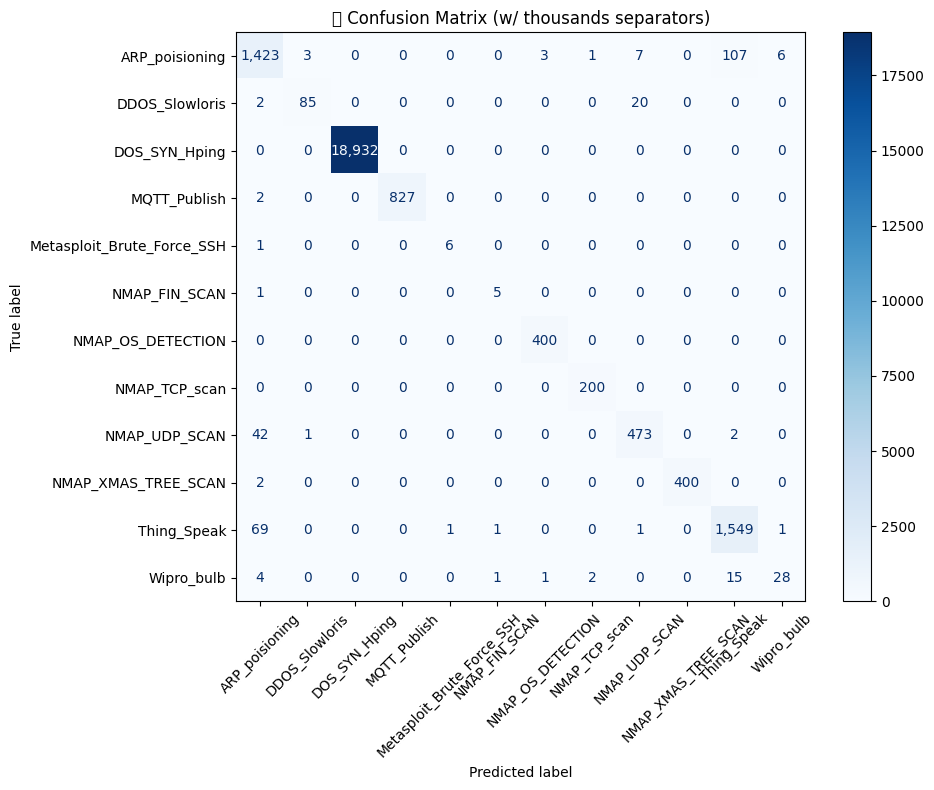

In [ ]:
# Predict
y_pred = lr_model.predict(X_test)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy:  {acc:,.4f}")
print(f"✅ Precision: {prec:,.4f}")
print(f"✅ Recall:    {rec:,.4f}")
print(f"✅ F1 Score:  {f1:,.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(
    include_values=True,
    cmap='Blues',
    ax=ax,
    xticks_rotation=45,
    values_format=','
)

plt.title("📌 Confusion Matrix (w/ thousands separators)")
plt.tight_layout()
plt.grid(False)
plt.show()


In [ ]:
# Combine true and predicted labels into a DataFrame
vis_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred
})

# Sample up to 1000 from each class
vis_df_sampled = vis_df.groupby('true', group_keys=False).apply(
    lambda g: g.sample(n=min(len(g), 1000), random_state=42)
)

# Map back to readable class names
vis_df_sampled['true_name'] = le.inverse_transform(vis_df_sampled['true'])
vis_df_sampled['pred_name'] = le.inverse_transform(vis_df_sampled['pred'])

print("✅ Sampled for Visualization:")
print(vis_df_sampled['true_name'].value_counts())


✅ Sampled for Visualization:
true_name
ARP_poisioning                1000
DOS_SYN_Hping                 1000
Thing_Speak                   1000
MQTT_Publish                   829
NMAP_UDP_SCAN                  518
NMAP_XMAS_TREE_SCAN            402
NMAP_OS_DETECTION              400
NMAP_TCP_scan                  200
DDOS_Slowloris                 107
Wipro_bulb                      51
Metasploit_Brute_Force_SSH       7
NMAP_FIN_SCAN                    6
Name: count, dtype: int64


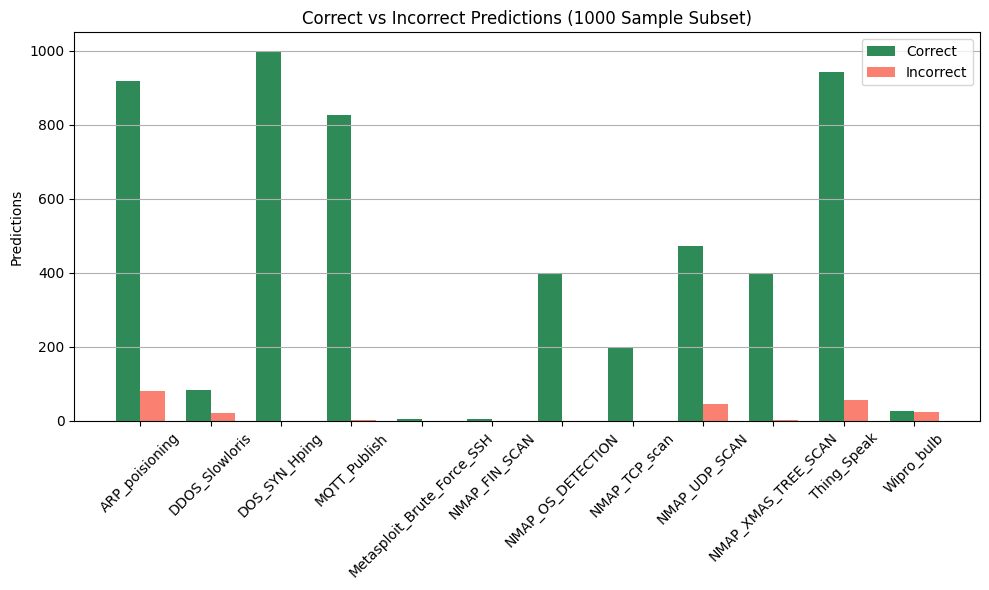

In [ ]:
correct_counts = []
incorrect_counts = []

for label in np.unique(vis_df_sampled['true']):
    correct = ((vis_df_sampled['true'] == label) & (vis_df_sampled['pred'] == label)).sum()
    total = (vis_df_sampled['true'] == label).sum()
    incorrect = total - correct
    correct_counts.append(correct)
    incorrect_counts.append(incorrect)

x_labels = le.inverse_transform(np.unique(vis_df_sampled['true']))
x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, correct_counts, width, label='Correct', color='seagreen')
ax.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='salmon')

ax.set_ylabel("Predictions")
ax.set_title("Correct vs Incorrect Predictions (1000 Sample Subset)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Multilayer Perceptron





In [ ]:
from sklearn.neural_network import MLPClassifier

# Train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict
y_pred_mlp = mlp_model.predict(X_test)



📋 MLP Classifier Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1550
           1       0.91      0.80      0.85       107
           2       1.00      1.00      1.00     18932
           3       1.00      1.00      1.00       829
           4       0.86      0.86      0.86         7
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00       400
           7       1.00      1.00      1.00       200
           8       0.95      0.98      0.97       518
           9       1.00      1.00      1.00       402
          10       0.98      0.99      0.99      1622
          11       0.96      0.84      0.90        51

    accuracy                           1.00     24624
   macro avg       0.97      0.94      0.95     24624
weighted avg       1.00      1.00      1.00     24624

✅ Accuracy:  0.9961
✅ Precision: 0.9961
✅ Recall:    0.9961
✅ F1 Score:  0.9961


In [ ]:
# Convert le.classes_ to a list of strings
target_names = [str(cls) for cls in le.classes_]

# Performance metrics
acc = accuracy_score(y_test, y_pred_mlp)
prec = precision_score(y_test, y_pred_mlp, average='weighted')
rec = recall_score(y_test, y_pred_mlp, average='weighted')
f1 = f1_score(y_test, y_pred_mlp, average='weighted')

print("📋 MLP Classifier Report:\n")
print(classification_report(y_test, y_pred_mlp, target_names=target_names)) # Use updated target_names

print(f"✅ Accuracy:  {acc:,.4f}")
print(f"✅ Precision: {prec:,.4f}")
print(f"✅ Recall:    {rec:,.4f}")
print(f"✅ F1 Score:  {f1:,.4f}")

📋 MLP Classifier Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1550
           1       0.91      0.80      0.85       107
           2       1.00      1.00      1.00     18932
           3       1.00      1.00      1.00       829
           4       0.86      0.86      0.86         7
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00       400
           7       1.00      1.00      1.00       200
           8       0.95      0.98      0.97       518
           9       1.00      1.00      1.00       402
          10       0.98      0.99      0.99      1622
          11       0.96      0.84      0.90        51

    accuracy                           1.00     24624
   macro avg       0.97      0.94      0.95     24624
weighted avg       1.00      1.00      1.00     24624

✅ Accuracy:  0.9961
✅ Precision: 0.9961
✅ Recall:    0.9961
✅ F1 Score:  0.9961


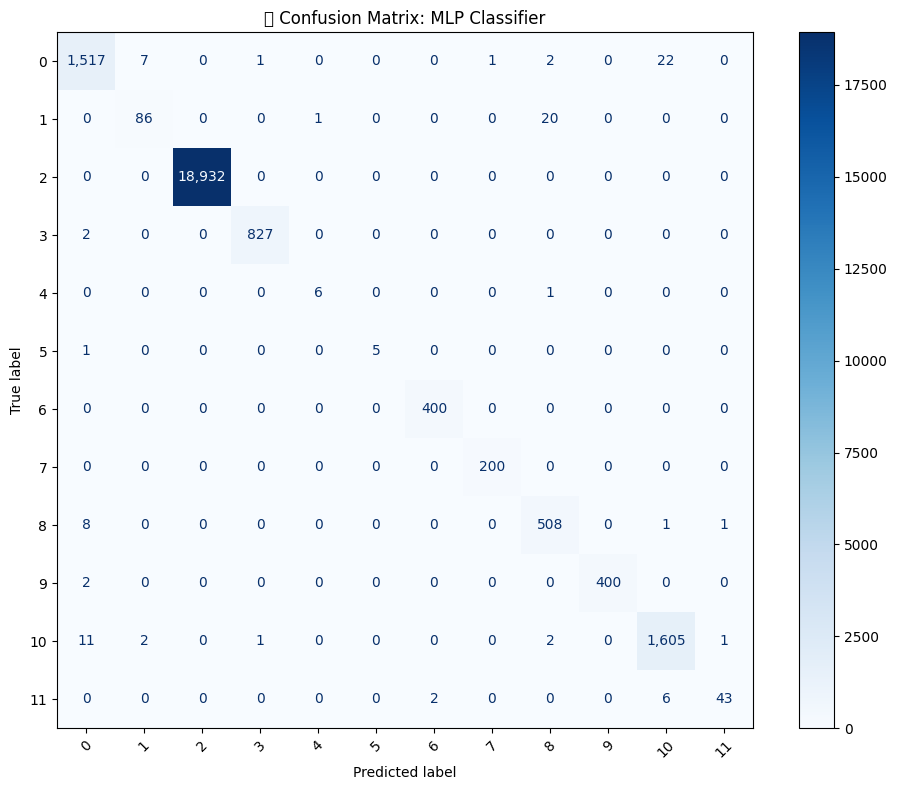

In [ ]:

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=le.classes_)
disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=45, values_format=',')
plt.title("📌 Confusion Matrix: MLP Classifier")
plt.tight_layout()
plt.grid(False)
plt.show()

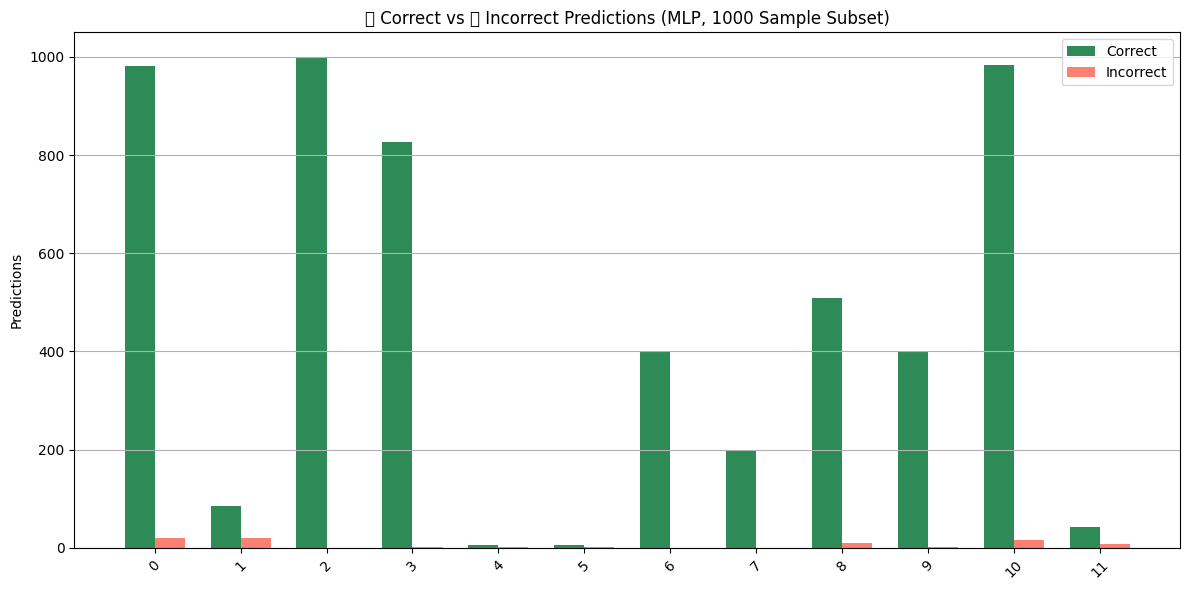

In [ ]:
# Build prediction DataFrame
vis_df_mlp = pd.DataFrame({
    'true': y_test,
    'pred': y_pred_mlp
})

# Sample up to 1000 per class
vis_df_sampled_mlp = vis_df_mlp.groupby('true', group_keys=False).apply(
    lambda g: g.sample(n=min(len(g), 1000), random_state=42)
)

# Add class names
vis_df_sampled_mlp['true_name'] = le.inverse_transform(vis_df_sampled_mlp['true'])
vis_df_sampled_mlp['pred_name'] = le.inverse_transform(vis_df_sampled_mlp['pred'])

# Count correct and incorrect predictions
correct_counts = []
incorrect_counts = []

for label in np.unique(vis_df_sampled_mlp['true']):
    correct = ((vis_df_sampled_mlp['true'] == label) &
               (vis_df_sampled_mlp['pred'] == label)).sum()
    total = (vis_df_sampled_mlp['true'] == label).sum()
    incorrect = total - correct
    correct_counts.append(correct)
    incorrect_counts.append(incorrect)

# Plot bar chart
x_labels = le.inverse_transform(np.unique(vis_df_sampled_mlp['true']))
x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, correct_counts, width, label='Correct', color='seagreen')
ax.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='salmon')
ax.set_ylabel("Predictions")
ax.set_title("✅ Correct vs ❌ Incorrect Predictions (MLP, 1000 Sample Subset)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
